# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.


### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

****

## Summary of Findings
***

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import scipy.stats as stats
import pylab

# matplotlib setup
%matplotlib inline

# turn edges on in plt
plt.rcParams["patch.force_edgecolor"] = True

np.random.seed(42)

In [2]:
# FUNCTIONS USED

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x: sort the data
    x = np.sort(data)

    # y: range for y-axis
    y = np.arange(1, n+1) / n

    return x, y

In [3]:
df = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')
df.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


## Generate some basic statistics about the data set

In [4]:
w = df[df.race == 'w']
b = df[df.race == 'b']

# white-sounding names
w_r = np.sum(w.call)
w_n = len(w)
w_p = (w_r / w_n)
print('WHITE\nTotal resumes: {}\ncallbacks: {}\nsuccess rate: {}%\n\n'.format(w_n, w_r, round(w_p * 100, 2)))

# black-sounding names
b_r = np.sum(b.call)
b_n = len(b)
b_p = (b_r / b_n)
print('BLACK\nTotal resumes: {}\ncallbacks: {}\nsuccess rate: {}%\n\n'.format(b_n, b_r, round(b_p * 100, 2)))

# aggregate values
r = np.sum(df.call)
n = len(df)
p = r/n
print('AGGREGATE\nTotal resumes: {}\ncallbacks: {}\nsuccess rate: {}%'.format(n, r, round(p * 100, 2)))

print('p: {}'.format(p))

WHITE
Total resumes: 2435
callbacks: 235.0
success rate: 9.65%


BLACK
Total resumes: 2435
callbacks: 157.0
success rate: 6.45%


AGGREGATE
Total resumes: 4870
callbacks: 392.0
success rate: 8.05%
p: 0.08049281314168377


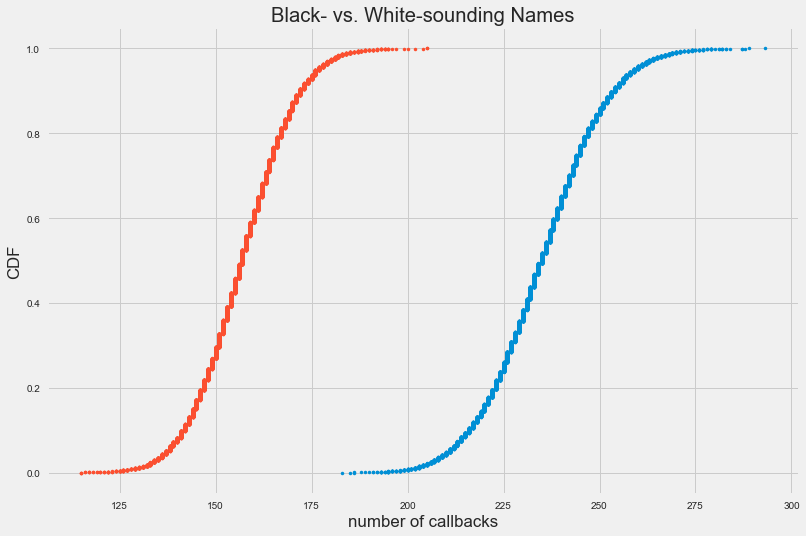

In [5]:
# Plot CDFs of callbacks for black- vs. white-sounding names

sns.set(rc={"figure.figsize": (12, 8)})
plt.style.use('fivethirtyeight')

w_samples = np.random.binomial(w_n, w_p, size=10000)
b_samples = np.random.binomial(b_n, b_p, size=10000)

wx, wy = ecdf(w_samples)
_ = plt.plot(wx, wy, marker='.', linestyle='none')

bx, by = ecdf(b_samples)
_ = plt.plot(bx, by, marker='.', linestyle='none')
plt.margins = 0.02
_ = plt.xlabel('number of callbacks')
_ = plt.ylabel('CDF')
_ = plt.title('Black- vs. White-sounding Names')
plt.show();

In [6]:
# threshold calculations for treatment as a normal distribution

print('White-sounding names')
print('n*p: ', w_n * w_p)
print('n*(1-p): ', w_n * (1-w_p))

print('\n\nBlack-sounding names')
print('n*p: ', b_n * b_p) 
print('n*(1-p)', b_n * (1-b_p))


White-sounding names
n*p:  235.0
n*(1-p):  2200.0


Black-sounding names
n*p:  157.0
n*(1-p) 2278.0


## Question #1: What is the appropriate test for this problem?
***
We are comparing the success rates (as measured by the percentage of callbacks received) of two separate sample sets (those with white-sounding names versus those with black-sounding names).  

A binomial distribution is the frequency distribution of the number of successes ($r$) in a given number of trials ($n$) with specified probability of success ($p$) in each trial.  Given a large enough sample size, the binomial distribution begins to approximate the normal distribution, as shown in the CDF plots above.  The number of samples is deemed to be large enough for a binomial distribution to be treated as a normal distribution provided that $n * p$ and $n(1-p)$ are both greater than 5 (some sources suggest greater than 10 or even 15).  In any case, our numbers are well above all three thresholds.

Given that we have a large enough number of samples that were drawn independently from the same distribution, which has a finite mean and variance, the Central Limit Theorem applies.

Since we are measuring the success rates of two binomial distributions, a two-sample test is called for.  The number of samples is large, so we may use the two-sample $Z$-test to calculate the margins of error, confidence intervals and p-values.

__BUT, we aren't given the standard deviation of the population.  We can get the standard deviation of the sample since we have a binomial and we know n & p, but is this sufficient or should we use the t-test?__

## Question #2: Null & Alternate Hypotheses
***
__Null Hypothesis__: the probability of success (getting a callback) is the same for both resumes with white-sounding names and black-sounding names.  
$$H_0: \widehat p_w = \widehat p_b$$  

__Alternate Hypothesis__: the probability of success IS NOT THE SAME for resumes with white-sounding names as it is for those with black-sounding names.  
$$H_a: \widehat p_w \neq \widehat p_b$$

## Question #3: Margin of Error, Confidence Interval and p-value testing
***


### Frequentist Approach

In [7]:
w = df[df.race=='w']
b = df[df.race=='b']

n_w = len(w)
n_b = len(b)

prop_w = np.sum(w.call) / len(w)
prop_b = np.sum(b.call) / len(b)

prop_diff = prop_w - prop_b
phat = (np.sum(w.call) + np.sum(b.call)) / (len(w) + len(b))

z = prop_diff / np.sqrt(phat * (1 - phat) * ((1 / n_w) + (1 / n_b)))
pval = stats.norm.cdf(-z) * 2
print("Z-score: {}".format(z))
print("p-value: {}".format(pval))

Z-score: 4.108412152434346
p-value: 3.983886837585077e-05


In [22]:
pc = (n_w * prop_w + n_b * prop_b)/ (n_w + n_b)
sigma = np.sqrt(pc*(1-pc)/n_w + pc*(1-pc)/n_b)
print('Standard deviation of the sample: {}'.format(sigma))

moe = 1.96 * np.sqrt(phat * (1 - phat) * ((1 / n_w) + (1 / n_b)))
print("Margin of Error: {}".format(moe))

# 95% confidence interval
ci = (prop_diff - moe, prop_diff + moe)

print("95% Confidence Interval: {}".format(ci))

sigma*1.96
moe*2
moe/1.96

Standard deviation of the sample: 0.007796894036170457
Margin of Error: 0.015281912310894095
95% Confidence Interval: (0.01675094189855149, 0.04731476652033968)


0.015281912310894095

0.03056382462178819

0.007796894036170457

### Bootstrap




In [31]:
# Construct arrays of data: white-sounding names, black-sounding names
w_cb = np.array([True] * 235 + [False] * 2200)
b_cb = np.array([True] * 157 + [False] * 2278)

# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(w_cb) - np.mean(b_cb)

# Get bootstrap replicates of means
size = 10000
bs_diff_replicates = np.empty(size)

for i in range(size):
    w_bs_replicates = np.random.choice(w_cb, len(w_cb))
    b_bs_replicates = np.random.choice(b_cb, len(b_cb))
    bs_diff_replicates[i] = np.mean(w_bs_replicates) - np.mean(b_bs_replicates)

# Compute 95% confidence interval: conf_int
(ci_low, ci_high) = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('Difference of sample means =', mean_diff)
print('Difference of bootstrap replicate means =', np.mean(bs_diff_replicates))
print('95% confidence interval = {} - {}'.format(ci_low, ci_high))

# Compute the p-value
p = np.sum(bs_diff_replicates == mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p-value =', p)

Difference of sample means = 0.032032854209445585
Difference of bootstrap replicate means = 0.03201905544147844
95% confidence interval = 0.016837782340862417 - 0.04722792607802875
p-value = 0.0193


### Permutation

In [29]:
# callbacks for WSNs - BSNs
def diff_frac(data_A, data_B):
    frac_A = np.sum(data_A == 1) / len(data_A)
    frac_B = np.sum(data_B == 1) / len(data_B)
    return frac_A - frac_B

#def diff_frac(a, b):
 #   """Compute fraction of a."""
  #  #frac = np.sum(a) / len(a)
   # frac = np.mean(a) - np.mean(b)
    #return frac

diff_frac_obs = diff_frac(w_cb, b_cb)

perm_replicates = np.empty(10000)

for i in range(10000):
    # Concatenate the data sets: data
    data = np.concatenate((w_cb, b_cb))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(w_cb)]
    perm_sample_2 = permuted_data[len(w_cb):]
    perm_replicates[i] = diff_frac(perm_sample_1, perm_sample_2)
    
# p-value: how many replicated differences are larger than the observed value
p_value = np.sum(perm_replicates >= diff_frac_obs) / len(perm_replicates)
print('p-value: {}'.format(p_value))

print('Difference of perm_replicate means =', np.mean(perm_replicates))

#(ci_perm_low, ci_perm_high) = np.percentile(perm_replicates, [2.5, 97.5])
print('95% confidence interval: {}'.format(np.percentile(perm_replicates, [2.5, 97.5])))
perm_replicates[:5]

p-value: 0.0
Difference of perm_replicate means = 0.0002004928131416838
95% confidence interval: [-0.01478439  0.01560575]


array([ 0.        , -0.00410678,  0.00574949, -0.00574949, -0.00574949])

### Analysis: 
The p-value for the Frequentist and Boostrap approaches are both well below the p=0.05 threshold so we must reject the null hypothesis in favor of the alternate hypothesis that perception of race based on the name on the resume does have an effect on whether an applicant will receive a callback.  The 95% confidence interval does not include 0, therefore, we can conclude that at least 95% of the samples taken will not result in the chances for callbacks being the same, regardless of name.

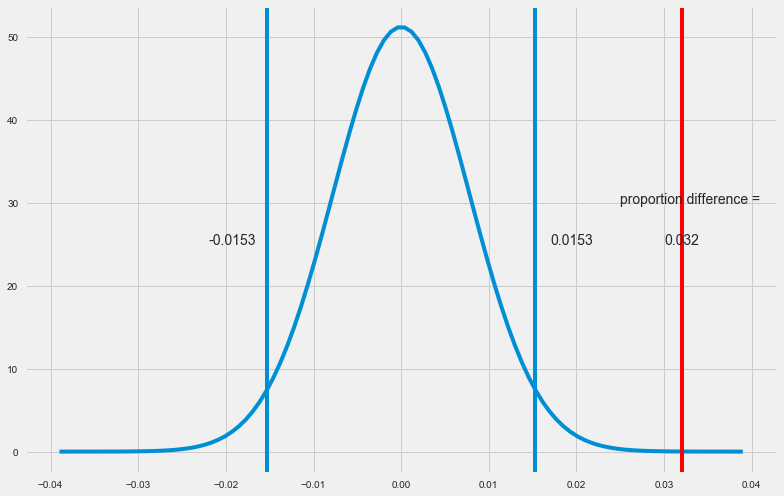

In [26]:
x = np.linspace(-5 * sigma, 5 * sigma, 100)
plt.plot(x, mlab.normpdf(x,0,sigma))
plt.axvline(moe)
plt.axvline(-moe)
plt.axvline(prop_diff,color='red')
plt.annotate(np.round(moe,4), (0.017,25))
plt.annotate(-np.round(moe,4), (-0.022,25))
plt.annotate('proportion difference = ', (0.025,30))
plt.annotate(np.round(prop_diff,4), (0.03,25))
plt.show();